In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
features = pd.read_csv('features.csv', delimiter=',')
features.head()

,product,productionCost,minMarkup,maxMarkup,date,sales,stock
0,431989,212837,59,80,2022-08-01,0,80
1,431989,212837,59,80,2022-04-01,0,103
2,431989,212837,59,80,2022-07-01,0,83
3,431989,212837,59,80,2022-06-01,0,89
4,431989,212837,59,80,2022-03-01,0,106


In [3]:
prices = pd.read_csv('prices.csv', delimiter=',')
prices.head()

,product,shop,category,brand,oldPrice,price,status,date
0,13309700,283,621641,1813,NaN,549000,1,2022-01-01
1,24023512,284,206776,315,NaN,249000,1,2022-01-01
2,21658969,5482,338678,1823,NaN,2817300,1,2022-01-01
3,12034393,283,621641,36731,NaN,1499000,1,2022-01-01
4,15431027,820,111964,1823,NaN,6999000,1,2022-01-01


In [4]:
csv = prices.merge(features, left_on=['product', 'date'], right_on=['product', 'date'])
csv = csv.drop('oldPrice', axis=1)
csv = csv.loc[csv['shop'].notnull()]
csv['date'] = pd.to_datetime(csv['date'])
csv = csv.sort_values(by=['date'])
csv.head()

,product,shop,category,brand,price,status,date,productionCost,minMarkup,maxMarkup,sales,stock
0,12544335,1820,111932,793,1899000,1,2022-01-03,1032328,58,80,1,187
1024,29098596,528,112008,368,26989000,1,2022-01-03,19172316,7,80,2,40
1023,29098596,3,112008,368,3479900,1,2022-01-03,19172316,7,80,2,40
1022,29098596,1816,112008,368,26989000,1,2022-01-03,19172316,7,80,2,40
1021,29098596,1820,112008,368,26989000,1,2022-01-03,19172316,7,80,2,40


In [5]:
def get_shop_product(csv, product, shop, category, brand):
    csv_t = csv
    csv_t = csv_t.loc[csv['product'] == product]
    csv_t = csv_t.loc[csv['category'] == category]
    csv_t = csv_t.loc[csv['brand'] == brand]

    csv = csv.loc[csv['product'] == product]
    csv = csv.loc[csv['shop'] == shop]
    csv = csv.loc[csv['category'] == category]
    csv = csv.loc[csv['brand'] == brand]

    csv = csv.drop('product', axis=1)
    csv = csv.drop('shop', axis=1)
    csv = csv.drop('category', axis=1)
    csv = csv.drop('brand', axis=1)

    csv = csv.drop('status', axis=1)
    csv = csv.drop('productionCost', axis=1)
    csv = csv.drop('minMarkup', axis=1)
    csv = csv.drop('maxMarkup', axis=1)

    date_time = csv.pop('date')

    avg_cost = []
    for date in date_time:
        csv_date = csv_t.loc[csv_t['date'] == date]
        avg_cost.append(csv_date['price'].mean())

    csv['avgPrice'] = avg_cost
    return csv, date_time

In [6]:
csv_sp, date_time = get_shop_product(csv, product=12544335, shop=1820, category=111932, brand=793)
timestamp_s = date_time.map(pd.Timestamp.timestamp)

month = 24*60*60*30
year = (365.2425)*month/30
csv_sp = csv_sp.assign(DaySin=np.sin(timestamp_s * (2 * np.pi / month)))
csv_sp = csv_sp.assign(DayCos=np.cos(timestamp_s * (2 * np.pi / month)))
csv_sp = csv_sp.assign(YearSin=np.sin(timestamp_s * (2 * np.pi / year)))
csv_sp = csv_sp.assign(YearCos=np.cos(timestamp_s * (2 * np.pi / year)))
csv_sp.head()

,price,sales,stock,avgPrice,DaySin,DayCos,YearSin,YearCos
0,1899000,1,187,1.809356e+06,0.866025,0.500000,0.041103,0.999155
1529,1899000,0,188,1.810111e+06,0.951057,0.309017,0.058284,0.998300
3085,1899000,0,188,1.898975e+06,0.994522,0.104528,0.075448,0.997150
5360,1899000,0,188,1.781017e+06,0.951057,-0.309017,0.109704,0.993964
6215,1899000,0,188,1.781017e+06,0.866025,-0.500000,0.126786,0.991930


In [7]:
column_indices = {name: i for i, name in enumerate(csv_sp.columns)}

n = len(csv_sp)
train_df = csv_sp[0:int(n*0.7)]
val_df = csv_sp[int(n*0.7):int(n*0.9)]
test_df = csv_sp[int(n*0.9):]

num_features = csv_sp.shape[1]

In [8]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
# print(train_std)
print(len(train_df), len(val_df), len(test_df))

140 40 21


In [9]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[
            self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[
            self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]]
                    for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='price', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(
                    plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

ONE STEP

In [10]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['price'])

In [11]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [12]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [13]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-02 10:44:18.512532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-02 10:44:18.512633: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 34ms/step - loss: 0.4928 - mean_absolute_error: 0.6187


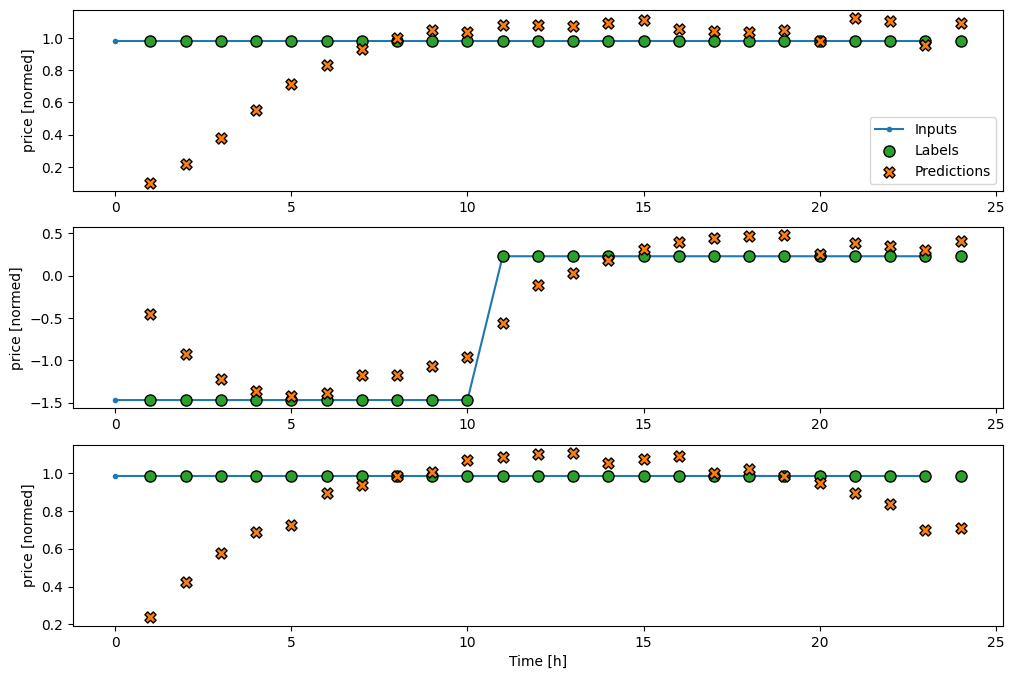

In [15]:
wide_window.plot(lstm_model)

MULTI STEP

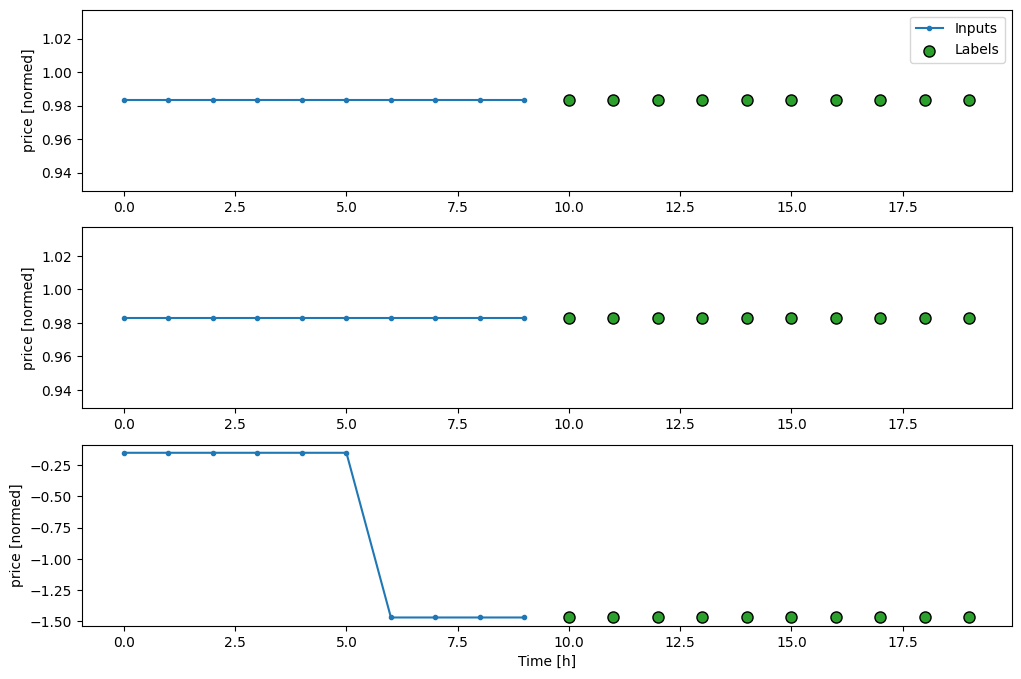

In [38]:
OUT_STEPS = int(len(test_df) / 2)
multi_window = WindowGenerator(input_width=OUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()

In [39]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [40]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [41]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 8])

In [42]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 10, 8)


1/1 [==============================] - 0s 51ms/step - loss: 1.4669 - mean_absolute_error: 0.9285


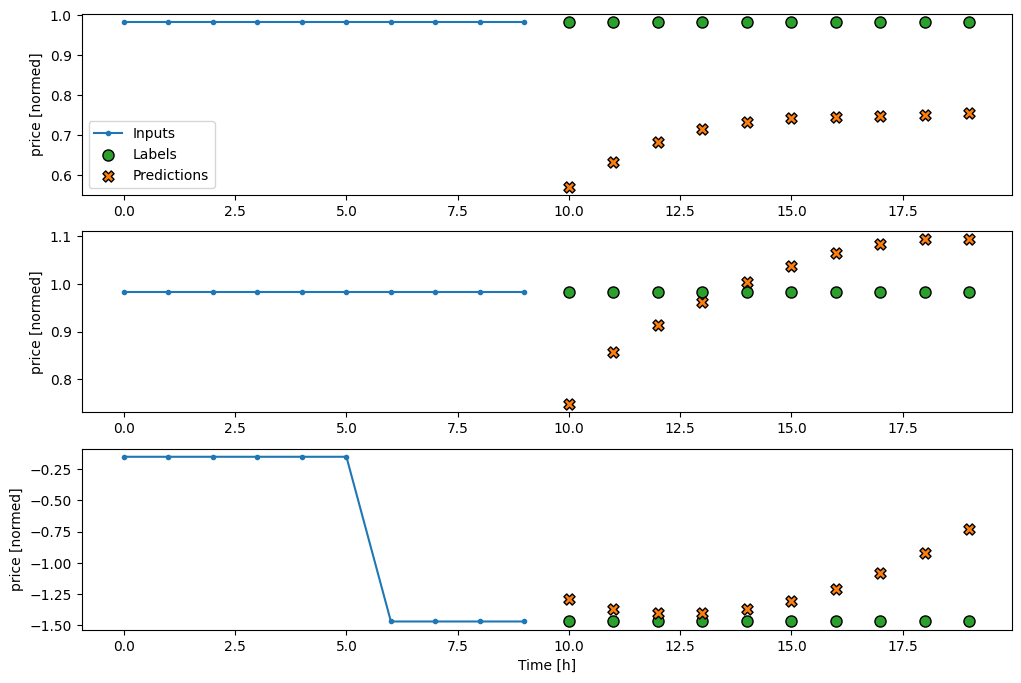

In [43]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance={}
multi_performance={}
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)